In [2]:
import pandas as pd
import glob 
import natsort
from sklearn.metrics import roc_auc_score
import numpy as np

score_df_paths = glob.glob('../scoring_results/alphabet/*')
score_df_paths = natsort.natsorted(score_df_paths)
score_df_paths





['../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_0_11_22_02_12_28_results.csv',
 '../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_20_11_25_00_30_30_results.csv',
 '../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_30_01_07_10_13_34_results.csv',
 '../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_40_11_24_10_24_05_results.csv',
 '../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_60_11_23_14_57_54_results.csv',
 '../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_80_01_13_05_48_15_results.csv',
 '../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_120_01_06_06_07_49_results.csv',
 '../scoring_results/alphabet/random_query_temperature_0.01_sample_n_30_random_str_length_200_12_22_20_56_39_results.csv',
 '../scoring_results/al

In [3]:
LENGTHS = [0, 20, 30, 40, 60, 80, 120, 200, 280, 400, 500, 600, 800, 1000]
assert len(LENGTHS) == len(score_df_paths) 

In [4]:

def extract_label_and_scores(df:pd.DataFrame):

    df  = df[['qid','factuality','pr_score','re_score','f1_score','question']]
    
    label_and_scores = {
        'label':[],
        'pr':[],
        're':[],
        'f1':[]
    }
    
    # set data type
    # df['factuality'] = df['factuality'].astype(str)
    
    for i in range(df.shape[0]):
        df.iloc[i]['factuality'] = str(df.iloc[i]['factuality'])
    
    for i in range(df.shape[0]):
        labels = df.iloc[i]['factuality'].split(',')
        pr_scores = df.iloc[i]['pr_score'].split(',')
        re_scores = df.iloc[i]['re_score'].split(',')
        f1_scores = df.iloc[i]['f1_score'].split(',')
        
        labels = [1 - int(x) for x in labels]
        pr_scores = [float(x) for x in pr_scores]
        re_scores = [float(x) for x in re_scores]
        f1_scores = [float(x) for x in f1_scores]
        
        assert len(labels) == len(pr_scores), f"labels: {labels}, pr_scores: {pr_scores},i: {i},q: {df.iloc[i]['question']}"
        
        label_and_scores['label'].extend(labels)
        label_and_scores['pr'].extend(pr_scores)
        label_and_scores['re'].extend(re_scores)
        label_and_scores['f1'].extend(f1_scores)
    
    import numpy as np
    label_and_scores["label"] = np.array(label_and_scores["label"])
    label_and_scores["pr"] = np.array(label_and_scores["pr"])
    label_and_scores["re"] = np.array(label_and_scores["re"])
    label_and_scores["f1"] = np.array(label_and_scores["f1"])
    

    return label_and_scores


def calc_auc_roc(df:pd.DataFrame):
    
    label_and_scores = extract_label_and_scores(df.copy())

    roc_aucs = {
        'pr':roc_auc_score(label_and_scores['label'],label_and_scores['pr']),
        're':roc_auc_score(label_and_scores['label'],label_and_scores['re']),
        'f1':roc_auc_score(label_and_scores['label'],label_and_scores['f1']),
        "ave":roc_auc_score(label_and_scores['label'],(label_and_scores['pr'] + label_and_scores['re'] + label_and_scores['f1'])/3),
        'random' : roc_auc_score(label_and_scores['label'],np.random.rand(len(label_and_scores['label']))),
    }

    return roc_aucs['pr']



In [5]:
lengths_vs_auc = {}
for i, path in enumerate(score_df_paths):
    df = pd.read_csv(path)
    # print(f"length: {LENGTHS[i]}, auc: {calc_auc_roc(df.copy())}")
    auc = calc_auc_roc(df.copy())
    lengths_vs_auc[LENGTHS[i]] = auc
from pprint import pprint
pprint(lengths_vs_auc)

{0: 0.490364277320799,
 20: 0.6597532314923619,
 30: 0.6762632197414806,
 40: 0.6840775558166862,
 60: 0.6950940070505288,
 80: 0.6997356051703879,
 120: 0.7173619271445357,
 200: 0.7224441833137486,
 280: 0.7243243243243243,
 400: 0.7190364277320799,
 500: 0.7168625146886016,
 600: 0.7192714453584019,
 800: 0.7210340775558167,
 1000: 0.7198002350176264}


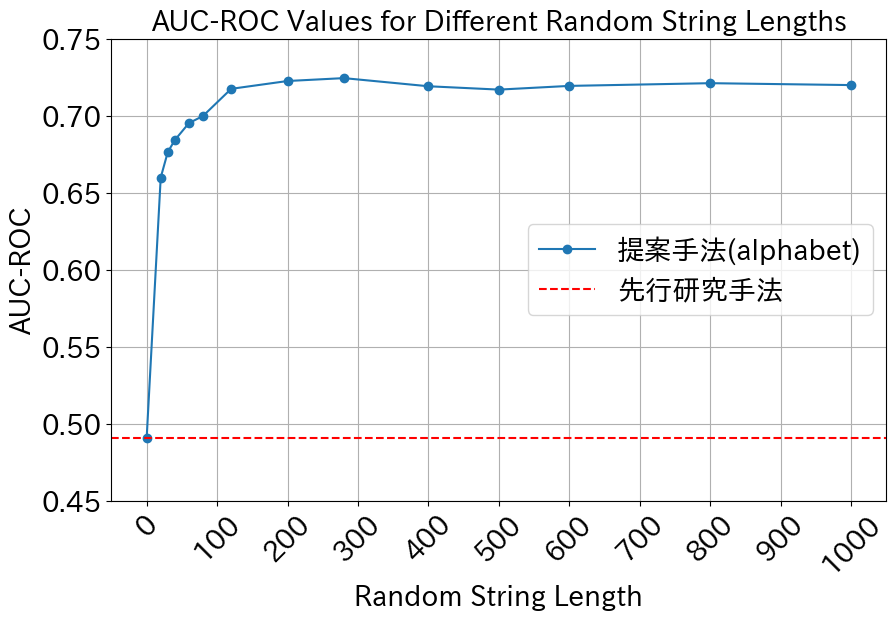

In [6]:
# graphにする
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
# Data
string_lengths = lengths_vs_auc.keys()
auc_roc_values =  lengths_vs_auc.values()
font_size = 20
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(string_lengths, auc_roc_values, marker='o',)
plt.title('AUC-ROC Values for Different Random String Lengths', fontsize=font_size)
plt.xlabel('Random String Length', fontsize=font_size)
plt.ylabel('AUC-ROC', fontsize=font_size)
plt.xticks(np.arange(0, 1001, 100), fontsize=font_size, rotation=45)
plt.yticks(np.arange(0.45, 0.76, 0.05), fontsize=font_size)
plt.grid(True)


plt.axhline(y=lengths_vs_auc[0], color='r', linestyle='--')
# plt.axhline(y=0.7707692307692308, color='g', linestyle='--')

plt.legend(['提案手法(alphabet)', '先行研究手法','SelfCheckGPT(サンプリング時温度0.9)'], fontsize=font_size)


# 最高性能のところを→で示す
# plt.annotate('AUC-ROC 0.714', xy=(600, 0.7147), xytext=(700, 0.71),
#              arrowprops=dict(facecolor='black', shrink=0.01,width=1),
#              fontsize=font_size / 1.3)



plt.show()


